In [16]:
!pip install opencv-python pandas scikit-learn torch torchvision pillow matplotlib tqdm

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
# Definisci il percorso
path = '/content/drive/MyDrive/ProgettoDLA'
# Spostati nella directory
os.chdir(path)
# Verifica di essere nel posto giusto
print(os.getcwd())

In [17]:
!cp "/content/drive/MyDrive/ProgettoDLA/dataset_resized_3split_unbalanced_128.zip" "/content/dataset_resized_3split_unbalanced_128.zip"
!unzip -q "/content/dataset_resized_3split_unbalanced_128.zip" -d "/content/dataset_resized_3split_unbalanced_128"

"cp" non è riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"unzip" non è riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [18]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch # Se ti serve dopo
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
# import pandas as pd  <-- RIMOSSO

In [19]:
# --- CONFIGURAZIONE ---
ORIGINAL_DATASET_PATH = 'flowers'   # La tua cartella originale
PROCESSED_DIR = 'dataset_resized_3split_unbalanced_128'   # Dove salveremo le immagini pronte
IMG_SIZE = (128,128)

# Funzione per salvare le immagini su disco partendo da liste
def process_and_save(paths, labels, split_name):
    save_dir = os.path.join(PROCESSED_DIR, split_name)
    print(f"Elaborazione e salvataggio: {split_name}...")

    # Usiamo zip per iterare su percorsi ed etichette insieme
    for src_path, label in tqdm(zip(paths, labels), total=len(paths)):

        # Crea cartella classe se non esiste
        class_dir = os.path.join(save_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        # Carica immagine
        img = cv2.imread(src_path)
        if img is None:
            continue

        # Resize
        img = cv2.resize(img, IMG_SIZE)

        # Costruiamo il nome file di destinazione
        filename = os.path.basename(src_path)
        dst_path = os.path.join(class_dir, filename)

        # Salva immagine ridimensionata
        cv2.imwrite(dst_path, img)

# --- 1. CONTROLLO ESISTENZA DATASET ---
if os.path.exists(PROCESSED_DIR):
    print(f"La cartella '{PROCESSED_DIR}' esiste già.")
    print("Salto la creazione e il resize delle immagini.")

else:
    print(f"La cartella '{PROCESSED_DIR}' non esiste. Inizio creazione dataset...")
    if not os.path.exists(ORIGINAL_DATASET_PATH):
        os.makedirs(ORIGINAL_DATASET_PATH, exist_ok=True)
        raise FileNotFoundError(f"Inserisci le immagini in: {ORIGINAL_DATASET_PATH}")

    # --- A. SCANSIONE E RAGGRUPPAMENTO PER CLASSE ---
    # Usiamo un dizionario per raggruppare: {'rosa': [path1, path2], 'margherita': [...]}
    data_by_class = {}

    valid_extensions = ('.jpg', '.jpeg', '.png')

    for label in os.listdir(ORIGINAL_DATASET_PATH):
        class_dir = os.path.join(ORIGINAL_DATASET_PATH, label)
        if os.path.isdir(class_dir):
            data_by_class[label] = []
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(valid_extensions):
                    data_by_class[label].append(os.path.join(class_dir, filename))

    # Controllo se vuoto
    if not data_by_class:
        raise ValueError("Non ho trovato immagini o sottocartelle!")

    # --- B. BILANCIAMENTO ---
    # Troviamo il numero minimo di immagini tra tutte le classi
    # min_samples = min(len(paths) for paths in data_by_class.values())
    # print(f"Bilanciamento classi a {min_samples} immagini ciascuna.")

    all_paths = []
    all_labels = []

    for label, paths in data_by_class.items():
        # Mescoliamo le immagini per prenderne un campione casuale
        random.shuffle(paths)

        # Prendiamo solo le prime 'min_samples' immagini (Slicing)
        selected_paths = paths#[:min_samples]

        all_paths.extend(selected_paths)
        all_labels.extend([label] * len(selected_paths))

    # --- C. SPLIT ---
    # Usiamo train_test_split direttamente sulle liste
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_paths, all_labels,
        test_size=0.20,
        stratify=all_labels,
        random_state=42
    )

    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels,
        test_size=0.50,
        stratify=temp_labels,
        random_state=42
    )
            

    # --- D. SALVATAGGIO ---
    process_and_save(train_paths, train_labels, 'train')
    process_and_save(val_paths, val_labels, 'val')
    process_and_save(test_paths, test_labels, 'test') # Salviamo anche il test set

    print("Creazione dataset completata con split Train/Val/Test.")

# --- 2. CARICAMENTO DAL DATASET RIDIMENSIONATO ---
# (Questa parte rimane identica perché legge dalle cartelle fisiche create sopra)
print("\nCaricamento dati in memoria da disco...")

def load_from_processed_dir(split_name, class_map):
    images = []
    labels = []
    base_path = os.path.join(PROCESSED_DIR, split_name)

    for class_name, class_idx in class_map.items():
        class_path = os.path.join(base_path, class_name)
        if not os.path.exists(class_path):
            continue

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is None: continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0

            images.append(img)
            labels.append(class_idx)

    return np.array(images, dtype=np.float32), np.array(labels)

# Genera mappa classi
train_dir = os.path.join(PROCESSED_DIR, 'train')
if not os.path.exists(train_dir):
     raise FileNotFoundError(f"Errore: {train_dir} non trovato.")

classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

print(f"Classi trovate: {class_to_idx}")

X_train, y_train = load_from_processed_dir('train', class_to_idx)
X_val, y_val = load_from_processed_dir('val', class_to_idx)
X_test, y_test = load_from_processed_dir('test', class_to_idx)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

La cartella 'dataset_resized_3split_unbalanced_128' non esiste. Inizio creazione dataset...
Elaborazione e salvataggio: train...


100%|██████████| 13783/13783 [00:21<00:00, 649.11it/s]


Elaborazione e salvataggio: val...


100%|██████████| 1723/1723 [00:02<00:00, 690.24it/s]


Elaborazione e salvataggio: test...


100%|██████████| 1723/1723 [00:02<00:00, 693.32it/s]


Creazione dataset completata con split Train/Val/Test.

Caricamento dati in memoria da disco...
Classi trovate: {'astilbe': 0, 'bellflower': 1, 'black_eyed_susan': 2, 'calendula': 3, 'california_poppy': 4, 'carnation': 5, 'common_daisy': 6, 'coreopsis': 7, 'daffodil': 8, 'dandelion': 9, 'iris': 10, 'lavender': 11, 'lotus': 12, 'magnolia': 13, 'orchid': 14, 'rose': 15, 'sunflower': 16, 'tulip': 17, 'water_lily': 18}
X_train shape: (13783, 128, 128, 3)
y_train shape: (13783,)


=== STATISTICHE DATASET TRAIN ===
Numero totale immagini: 13783
Dimensione immagine: 128x128 con 3 canali
Valore minimo pixel: 0.00
Valore massimo pixel: 1.00

--- Conteggio Classi Train ---
Classe 0 (astilbe): 590 immagini
Classe 1 (bellflower): 698 immagini
Classe 2 (black_eyed_susan): 800 immagini
Classe 3 (calendula): 782 immagini
Classe 4 (california_poppy): 818 immagini
Classe 5 (carnation): 738 immagini
Classe 6 (common_daisy): 784 immagini
Classe 7 (coreopsis): 838 immagini
Classe 8 (daffodil): 776 immagini
Classe 9 (dandelion): 842 immagini
Classe 10 (iris): 843 immagini
Classe 11 (lavender): 400 immagini
Classe 12 (lotus): 400 immagini
Classe 13 (magnolia): 838 immagini
Classe 14 (orchid): 391 immagini
Classe 15 (rose): 799 immagini
Classe 16 (sunflower): 822 immagini
Classe 17 (tulip): 838 immagini
Classe 18 (water_lily): 786 immagini

--- Conteggio Classi Val ---
Classe 0 (astilbe): 74 immagini
Classe 1 (bellflower): 88 immagini
Classe 2 (black_eyed_susan): 100 immagini
Cla

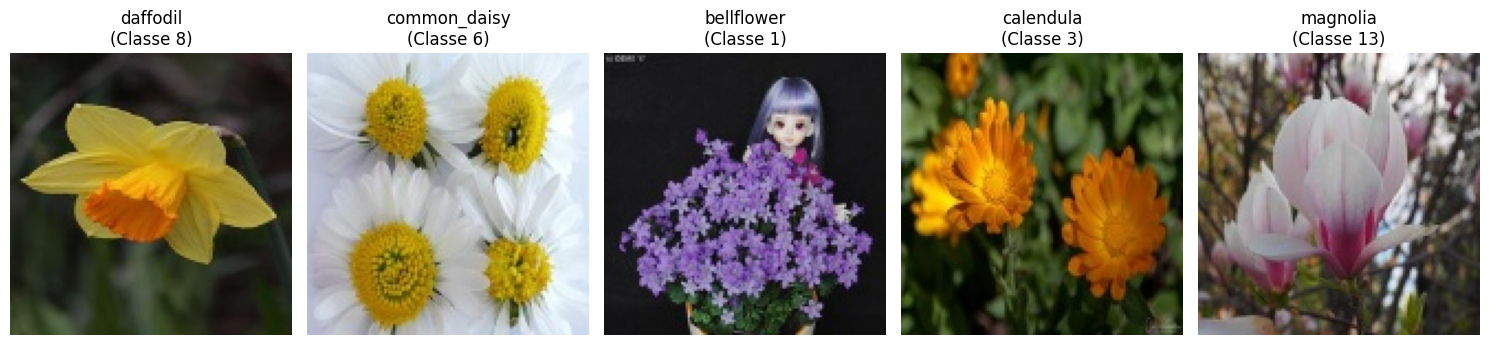

In [20]:
# --- 1. INFO NUMERICHE ---
print("=== STATISTICHE DATASET TRAIN ===")
print(f"Numero totale immagini: {X_train.shape[0]}")
print(f"Dimensione immagine: {X_train.shape[1]}x{X_train.shape[2]} con {X_train.shape[3]} canali")
print(f"Valore minimo pixel: {X_train.min():.2f}")
print(f"Valore massimo pixel: {X_train.max():.2f}")

print("\n--- Conteggio Classi Train ---")
unique, counts = np.unique(y_train, return_counts=True)
idx_to_class = {v: k for k, v in class_to_idx.items()} # Mappa inversa utile

for label_idx, count in zip(unique, counts):
    nome_classe = idx_to_class[label_idx]
    print(f"Classe {label_idx} ({nome_classe}): {count} immagini")

print("\n--- Conteggio Classi Val ---")
unique_val, counts_val = np.unique(y_val, return_counts=True)
for label_idx, count in zip(unique_val, counts_val):
    nome_classe = idx_to_class[label_idx]
    print(f"Classe {label_idx} ({nome_classe}): {count} immagini")

# --- 2. VISUALIZZAZIONE ESEMPI ---
print("\nESEMPI VISIVI RANDOM")
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    idx_random = np.random.randint(0, len(X_train))
    img = X_train[idx_random]
    label = y_train[idx_random]
    nome_label = idx_to_class[label]

    axes[i].imshow(img)
    axes[i].set_title(f"{nome_label}\n(Classe {label})")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [21]:
# 1. Configurazione Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(" Usando accelerazione Apple MPS (Metal)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(" Usando accelerazione CUDA (GPU)")
else:
    device = torch.device("cpu")
    print(" MPS e CUDA non trovati, uso CPU")

# 2. Conversione da Numpy a Tensor
# PyTorch vuole (N, Canali, Altezza, Larghezza) -> usiamo permute
# Assicuriamoci che siano float32
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 3. DataLoader
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dati caricati nei Loader. Batch size: {batch_size}")

 Usando accelerazione CUDA (GPU)
Dati caricati nei Loader. Batch size: 32


In [ ]:
import torch
import torch.nn as nn

class OptimizedCNN(nn.Module):
    def __init__(self, num_classes):
        super(OptimizedCNN, self).__init__()

        # --- BLOCCO ESTRAZIONE FEATURES ---
        # Nota: Impostiamo bias=False perché la Batch Normalization successiva
        # introduce già un termine di "shift" (beta), rendendo il bias della conv ridondante.
        
        # Blocco 1: Low-level features
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True), # inplace=True risparmia memoria
            nn.MaxPool2d(2, 2)  # 128 -> 64
        )

        # Blocco 2: Mid-level features
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 64 -> 32
        )

        # Blocco 3: High-level features
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 32 -> 16
        )

        # Blocco 4: Semantic features
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 16 -> 8
        )

        # --- CLASSIFICATORE ---
        # Global Average Pooling: riduce drasticamente i parametri
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5), # Regolarizzazione
            nn.Linear(256, num_classes)
        )
        
        # Inizializzazione pesi esplicita
        self._initialize_weights()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        """
        Applica la He Initialization (Kaiming) come raccomandato
        per evitare che la varianza si dimezzi a causa della ReLU.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # mode='fan_out' preserva la varianza nel passaggio backward
                # nonlinearity='relu' è fondamentale per il calcolo del fattore sqrt(2/n)
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.BatchNorm2d):
                # Inizializzazione standard per BN: peso=1, bias=0
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.Linear):
                # Per il layer lineare finale
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

NUM_CLASSES = len(class_to_idx)
print(f"Configurazione modello per {NUM_CLASSES} classi.")

model = OptimizedCNN(num_classes=NUM_CLASSES)
# Calcolo parametri
params = sum(p.numel() for p in model.parameters())
print(f"Modello creato. Parametri totali: {params:,}")

Configurazione modello per 19 classi.
Modello creato. Parametri totali: 393,779


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

#  CONFIGURAZIONE 
lr = 1e-3
weight_decay = 1e-5
EPOCHS = 50
PATIENCE = 5  # Numero di epoche da attendere senza miglioramenti prima di fermarsi
print("")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(class_to_idx)



# 1. Creazione del Modello
model = OptimizedCNN(num_classes=NUM_CLASSES).to(device)

# 2. Ottimizzatore
# weight_decay implementa la Regolarizzazione L2 
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# 3. Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
print(f"CONFIGURAZIONE ATTUALE")

print(f"Epoche:          {EPOCHS}")
print(f"Early Stopping:  Patience = {PATIENCE}")
print(f"Learning Rate:   {lr:.1e}")           # Stampa la variabile lr
print(f"Weight Decay:    {weight_decay:.1e}") # Stampa la variabile weight_decay
print(f"SCHEDULER")
print(f"Step Size:       Ogni {scheduler.step_size} epoche")
print(f"Gamma:           {scheduler.gamma} (moltiplicatore LR)")

# 4. Loss Function
criterion = nn.CrossEntropyLoss()

print(f"Inizio training su device: {device}")

# Variabili per Early Stopping
best_val_acc = 0.0
patience_counter = 0

# Liste per lo storico
history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}

# --- TRAINING LOOP ---
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoca {epoch+1}/{EPOCHS}", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistiche
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        loop.set_postfix(loss=loss.item())

    # Aggiornamento Scheduler
    scheduler.step()
    
    # Calcolo metriche Training
    epoch_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    current_lr = optimizer.param_groups[0]['lr']

    # --- VALIDATION LOOP ---
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val

    # Salvataggio storico
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    print(f"Epoca {epoch+1:02d} | LR: {current_lr:.1e} | Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # --- EARLY STOP ---
    # Controlliamo se l'accuratezza in validazione è migliorata
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0  # Reset contatore
        # Salviamo il modello migliore (checkpoint)
        torch.save(model.state_dict(), 'best_model.pth')
    
    else:
        patience_counter += 1
        print(f"   --> Nessun miglioramento. Patience: {patience_counter}/{PATIENCE}")
        
        # Se abbiamo superato la pazienza, fermiamo il training
        if patience_counter >= PATIENCE:
            print("\nEARLY STOPPING ACTIVATED")
            print(f"Il training si ferma perché la Val Acc non migliora da {PATIENCE} epoche.")
            break

print("Training completato!")

# Carica i pesi migliori prima di uscire/testare
model.load_state_dict(torch.load('best_model.pth'))
print(f"Caricati i pesi del modello migliore con Val Acc: {best_val_acc:.2f}%")


CONFIGURAZIONE ATTUALE
Epoche:          50
Early Stopping:  Patience = 5
Learning Rate:   1.0e-03
Weight Decay:    1.0e-05
SCHEDULER
Step Size:       Ogni 5 epoche
Gamma:           0.5 (moltiplicatore LR)
Inizio training su device: cuda


Epoca 01 | LR: 1.0e-03 | Loss: 2.0270 | Train Acc: 33.80% | Val Acc: 44.69%


Epoca 02 | LR: 1.0e-03 | Loss: 1.6334 | Train Acc: 46.45% | Val Acc: 40.57%
   --> Nessun miglioramento. Patience: 1/5


Epoca 03 | LR: 1.0e-03 | Loss: 1.4924 | Train Acc: 51.63% | Val Acc: 58.62%


Epoca 04 | LR: 1.0e-03 | Loss: 1.3574 | Train Acc: 55.81% | Val Acc: 60.30%


Epoca 05 | LR: 5.0e-04 | Loss: 1.2554 | Train Acc: 59.64% | Val Acc: 59.32%
   --> Nessun miglioramento. Patience: 1/5


Epoca 06 | LR: 5.0e-04 | Loss: 1.1047 | Train Acc: 65.11% | Val Acc: 66.98%


Epoca 07 | LR: 5.0e-04 | Loss: 1.0422 | Train Acc: 66.97% | Val Acc: 65.41%
   --> Nessun miglioramento. Patience: 1/5


Epoca 08 | LR: 5.0e-04 | Loss: 0.9941 | Train Acc: 68.24% | Val Acc: 66.69%
   --> Nessun miglioramento. Patience: 2/5


Epoca 09 | LR: 5.0e-04 | Loss: 0.9621 | Train Acc: 69.47% | Val Acc: 70.40%


Epoca 10 | LR: 2.5e-04 | Loss: 0.9035 | Train Acc: 70.95% | Val Acc: 71.74%


Epoca 11 | LR: 2.5e-04 | Loss: 0.8461 | Train Acc: 73.09% | Val Acc: 74.17%


Epoca 12 | LR: 2.5e-04 | Loss: 0.8094 | Train Acc: 74.35% | Val Acc: 76.38%


Epoca 13 | LR: 2.5e-04 | Loss: 0.7953 | Train Acc: 74.87% | Val Acc: 76.09%
   --> Nessun miglioramento. Patience: 1/5


Epoca 14 | LR: 2.5e-04 | Loss: 0.7753 | Train Acc: 75.48% | Val Acc: 76.84%


Epoca 15 | LR: 1.3e-04 | Loss: 0.7525 | Train Acc: 76.49% | Val Acc: 77.95%


Epoca 16 | LR: 1.3e-04 | Loss: 0.7049 | Train Acc: 77.76% | Val Acc: 80.09%


Epoca 17 | LR: 1.3e-04 | Loss: 0.6864 | Train Acc: 78.36% | Val Acc: 79.69%
   --> Nessun miglioramento. Patience: 1/5


Epoca 18 | LR: 1.3e-04 | Loss: 0.6799 | Train Acc: 78.35% | Val Acc: 78.53%
   --> Nessun miglioramento. Patience: 2/5


Epoca 19 | LR: 1.3e-04 | Loss: 0.6841 | Train Acc: 78.37% | Val Acc: 79.80%
   --> Nessun miglioramento. Patience: 3/5


Epoca 20 | LR: 6.3e-05 | Loss: 0.6723 | Train Acc: 79.01% | Val Acc: 79.57%
   --> Nessun miglioramento. Patience: 4/5


Epoca 21 | LR: 6.3e-05 | Loss: 0.6465 | Train Acc: 79.71% | Val Acc: 81.37%


Epoca 22 | LR: 6.3e-05 | Loss: 0.6490 | Train Acc: 79.51% | Val Acc: 81.49%


Epoca 23 | LR: 6.3e-05 | Loss: 0.6418 | Train Acc: 79.90% | Val Acc: 81.14%
   --> Nessun miglioramento. Patience: 1/5


Epoca 24 | LR: 6.3e-05 | Loss: 0.6284 | Train Acc: 80.36% | Val Acc: 81.72%


Epoca 25 | LR: 3.1e-05 | Loss: 0.6176 | Train Acc: 80.77% | Val Acc: 81.72%
   --> Nessun miglioramento. Patience: 1/5


Epoca 26 | LR: 3.1e-05 | Loss: 0.6073 | Train Acc: 80.72% | Val Acc: 82.12%


Epoca 27 | LR: 3.1e-05 | Loss: 0.6059 | Train Acc: 81.09% | Val Acc: 82.18%


Epoca 28 | LR: 3.1e-05 | Loss: 0.6041 | Train Acc: 80.72% | Val Acc: 82.01%
   --> Nessun miglioramento. Patience: 1/5


Epoca 29 | LR: 3.1e-05 | Loss: 0.6069 | Train Acc: 80.76% | Val Acc: 81.95%
   --> Nessun miglioramento. Patience: 2/5


Epoca 30 | LR: 1.6e-05 | Loss: 0.6030 | Train Acc: 80.55% | Val Acc: 82.12%
   --> Nessun miglioramento. Patience: 3/5


Epoca 31 | LR: 1.6e-05 | Loss: 0.5981 | Train Acc: 81.13% | Val Acc: 82.01%
   --> Nessun miglioramento. Patience: 4/5


Epoca 32 | LR: 1.6e-05 | Loss: 0.6003 | Train Acc: 80.99% | Val Acc: 82.36%


Epoca 33 | LR: 1.6e-05 | Loss: 0.6055 | Train Acc: 80.77% | Val Acc: 82.30%
   --> Nessun miglioramento. Patience: 1/5


Epoca 34 | LR: 1.6e-05 | Loss: 0.5916 | Train Acc: 81.05% | Val Acc: 82.82%


Epoca 35 | LR: 7.8e-06 | Loss: 0.5893 | Train Acc: 81.60% | Val Acc: 82.65%
   --> Nessun miglioramento. Patience: 1/5


Epoca 36 | LR: 7.8e-06 | Loss: 0.5887 | Train Acc: 81.35% | Val Acc: 82.47%
   --> Nessun miglioramento. Patience: 2/5


Epoca 37 | LR: 7.8e-06 | Loss: 0.5901 | Train Acc: 81.14% | Val Acc: 83.11%


Epoca 38 | LR: 7.8e-06 | Loss: 0.5867 | Train Acc: 81.62% | Val Acc: 82.30%
   --> Nessun miglioramento. Patience: 1/5


Epoca 39 | LR: 7.8e-06 | Loss: 0.5803 | Train Acc: 81.63% | Val Acc: 82.12%
   --> Nessun miglioramento. Patience: 2/5


Epoca 40 | LR: 3.9e-06 | Loss: 0.5848 | Train Acc: 81.72% | Val Acc: 82.47%
   --> Nessun miglioramento. Patience: 3/5


Epoca 41 | LR: 3.9e-06 | Loss: 0.5896 | Train Acc: 81.50% | Val Acc: 83.23%


Epoca 42 | LR: 3.9e-06 | Loss: 0.5821 | Train Acc: 81.35% | Val Acc: 82.18%
   --> Nessun miglioramento. Patience: 1/5


Epoca 43 | LR: 3.9e-06 | Loss: 0.5861 | Train Acc: 81.31% | Val Acc: 82.76%
   --> Nessun miglioramento. Patience: 2/5


Epoca 44 | LR: 3.9e-06 | Loss: 0.5830 | Train Acc: 81.64% | Val Acc: 82.76%
   --> Nessun miglioramento. Patience: 3/5


Epoca 45 | LR: 2.0e-06 | Loss: 0.5868 | Train Acc: 81.26% | Val Acc: 82.76%
   --> Nessun miglioramento. Patience: 4/5


Epoca 46 | LR: 2.0e-06 | Loss: 0.5746 | Train Acc: 81.97% | Val Acc: 83.05%
   --> Nessun miglioramento. Patience: 5/5

EARLY STOPPING ACTIVATED
Il training si ferma perché la Val Acc non migliora da 5 epoche.
Training completato!
Caricati i pesi del modello migliore con Val Acc: 83.23%


In [53]:
print("--- VALUTAZIONE CUSTOM CNN SU TEST SET ---")
model.eval()
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader: # Usa TEST set
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Salviamo per eventuale matrice di confusione
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct_test / total_test
print(f"Accuracy finale sul Test Set: {test_acc:.2f}%")

--- VALUTAZIONE CUSTOM CNN SU TEST SET ---
Accuracy finale sul Test Set: 83.75%


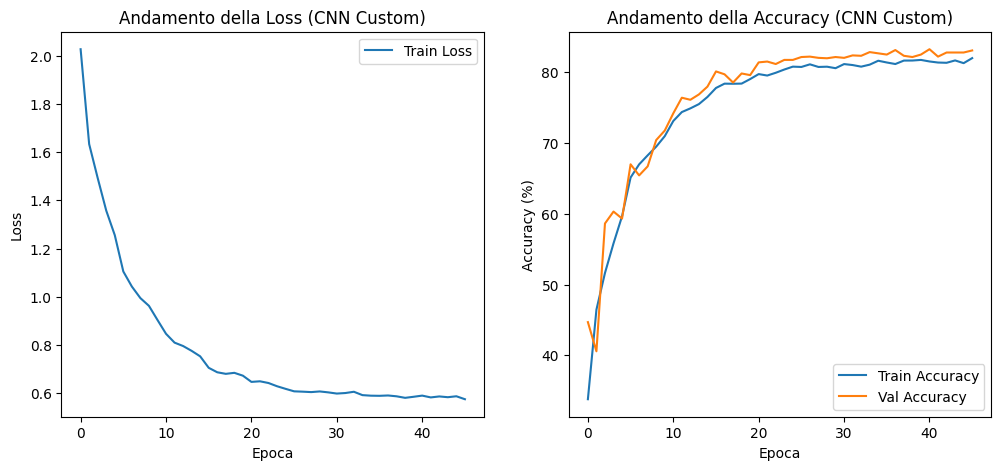

In [54]:
plt.figure(figsize=(12, 5))

# Grafico Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Andamento della Loss (CNN Custom)')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

# Grafico Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy') # Questo è il validation!
plt.title('Andamento della Accuracy (CNN Custom)')
plt.xlabel('Epoca')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [26]:
# --- CONFIGURAZIONE E TRAINING MOBILENET V2 ---
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

print("=== 1. PREPARAZIONE MOBILENET V2 ===")

# 1. Caricamento pesi pre-addestrati
weights_mb2 = models.MobileNet_V2_Weights.DEFAULT
model_mb2 = models.mobilenet_v2(weights=weights_mb2)

# 2. Freezing (Congeliamo la parte features)
for param in model_mb2.features.parameters():
    param.requires_grad = False

#

# 3. Sostituzione dell'ultimo layer (Testa)
#    In MobileNetV2, 'classifier' è un Sequential con:
#    [0] -> Dropout
#    [1] -> Linear (questo è quello che dobbiamo cambiare)
in_features = model_mb2.classifier[1].in_features
model_mb2.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

# 4. Spostamento su Device
model_mb2 = model_mb2.to(device)

print(f"Modello V2 pronto. Parametri addestrabili: {sum(p.numel() for p in model_mb2.parameters() if p.requires_grad):,}")

# --- CONFIGURAZIONE TRAINING ---
optimizer = optim.Adam(model_mb2.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs_transfer = 30

# Liste per storico
history_mb2 = {'train_loss': [], 'train_acc': [], 'val_acc': []}

print(f"\n=== 2. INIZIO TRAINING (MobileNetV2) per {epochs_transfer} epoche ===")

for epoch in range(epochs_transfer):
    model_mb2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs_transfer}", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_mb2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item())

    # Statistiche epoca
    epoch_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # Validazione
    model_mb2.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_mb2(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val

    # Salvataggio dati
    history_mb2['train_loss'].append(epoch_loss)
    history_mb2['train_acc'].append(train_acc)
    history_mb2['val_acc'].append(val_acc)

    print(f"Epoca {epoch+1:02d} | Loss: {epoch_loss:.4f} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}%")

print("\nTraining MobileNetV2 completato!")

=== 1. PREPARAZIONE MOBILENET V2 ===
Modello V2 pronto. Parametri addestrabili: 24,339

=== 2. INIZIO TRAINING (MobileNetV2) per 30 epoche ===


Epoca 01 | Loss: 2.3282 | Train: 44.13% | Val: 66.22%


Epoca 02 | Loss: 1.6061 | Train: 67.03% | Val: 72.43%


Epoca 03 | Loss: 1.2861 | Train: 71.58% | Val: 74.75%


Epoca 04 | Loss: 1.1119 | Train: 73.54% | Val: 75.86%


Epoca 05 | Loss: 0.9977 | Train: 75.46% | Val: 77.66%


Epoca 06 | Loss: 0.9289 | Train: 76.17% | Val: 79.11%


Epoca 07 | Loss: 0.8732 | Train: 76.91% | Val: 79.51%


Epoca 08 | Loss: 0.8314 | Train: 77.70% | Val: 79.74%


Epoca 09 | Loss: 0.7929 | Train: 78.51% | Val: 80.09%


Epoca 10 | Loss: 0.7600 | Train: 79.16% | Val: 80.44%


Epoca 11 | Loss: 0.7409 | Train: 79.45% | Val: 79.74%


Epoca 12 | Loss: 0.7162 | Train: 80.05% | Val: 81.14%


Epoca 13 | Loss: 0.7060 | Train: 79.86% | Val: 81.02%


Epoca 14 | Loss: 0.6906 | Train: 80.32% | Val: 81.02%


Epoca 15 | Loss: 0.6708 | Train: 80.98% | Val: 81.37%


Epoca 16 | Loss: 0.6604 | Train: 80.82% | Val: 81.95%


Epoca 17 | Loss: 0.6481 | Train: 81.46% | Val: 82.18%


Epoca 18 | Loss: 0.6398 | Train: 81.69% | Val: 82.76%


Epoca 19 | Loss: 0.6235 | Train: 81.80% | Val: 82.30%


Epoca 20 | Loss: 0.6184 | Train: 82.10% | Val: 82.59%


Epoca 21 | Loss: 0.6203 | Train: 81.73% | Val: 83.11%


Epoca 22 | Loss: 0.6078 | Train: 82.09% | Val: 83.11%


Epoca 23 | Loss: 0.5928 | Train: 82.46% | Val: 83.34%


Epoca 24 | Loss: 0.5943 | Train: 82.46% | Val: 82.82%


Epoca 25 | Loss: 0.5696 | Train: 83.10% | Val: 83.52%


Epoca 26 | Loss: 0.5805 | Train: 82.95% | Val: 82.76%


Epoca 27 | Loss: 0.5742 | Train: 83.02% | Val: 83.63%


Epoca 28 | Loss: 0.5651 | Train: 83.11% | Val: 83.69%


Epoca 29 | Loss: 0.5621 | Train: 83.46% | Val: 83.28%


Epoca 30 | Loss: 0.5524 | Train: 83.48% | Val: 83.34%

Training MobileNetV2 completato!


In [55]:
print("--- VALUTAZIONE MOBILENET V2 SU TEST SET ---")
model_mb2.eval()
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader: # Usa TEST set
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_mb2(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Salviamo per eventuale matrice di confusione
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct_test / total_test
print(f"Accuracy finale MobileNet V2 sul Test Set: {test_acc:.2f}%")

--- VALUTAZIONE MOBILENET V2 SU TEST SET ---
Accuracy finale MobileNet V2 sul Test Set: 85.32%


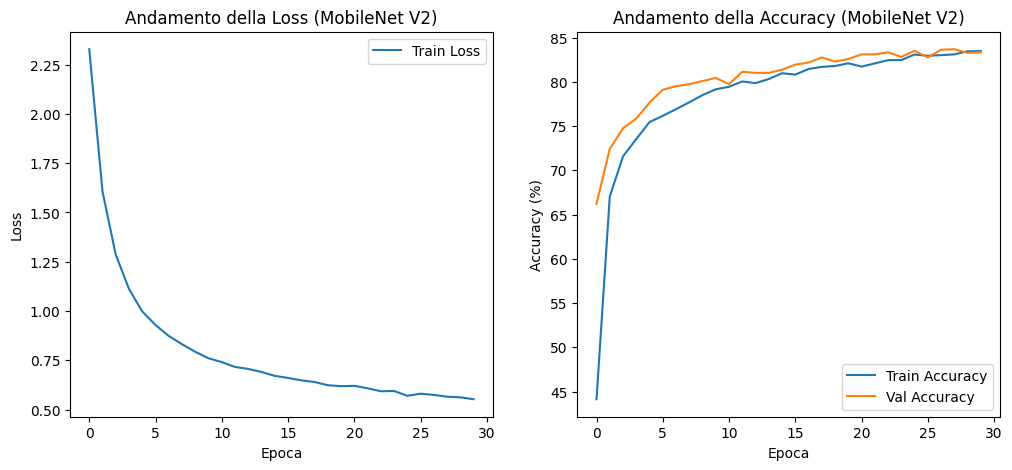

In [28]:
plt.figure(figsize=(12, 5))

# Grafico Loss
plt.subplot(1, 2, 1)
plt.plot(history_mb2['train_loss'], label='Train Loss')
plt.title('Andamento della Loss (MobileNet V2)')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

# Grafico Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mb2['train_acc'], label='Train Accuracy')
plt.plot(history_mb2['val_acc'], label='Val Accuracy') # Questo è il validation!
plt.title('Andamento della Accuracy (MobileNet V2)')
plt.xlabel('Epoca')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()